In [1]:
import warnings
warnings.filterwarnings('ignore')

## QBUS3850 Lab 4 (ARIMA Models) Task

In this tutorial we will work on the Minneapolis traffic data available on Canvas. This data contains daily observations of traffic volume and was originally sourced from John Hogue who made it available at the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). Some post-processing of the data has been carried out.

Your task will be to use all data up to 2018-07-31 to forecast the next two months ahead (August and September 2018). You will use the following models

- An AR(2)
- An MA(2)
- An ARIMA selected by auto_arima
- A seasonal ARIMA selected by auto_arima 
- A regression with holiday dummies and errors following seasonal ARIMA selected by auto_arima 
- A regression with holiday dummies and two pairs of (i.e.four) Fourier terms and errors following seasonal ARIMA selected by auto_arima

After estimating each model, plot the forecasts together with some training data and the test data. Comment on how the forecasts reflect the properties of each model.

### Preliminary analysis

First import and plot the data

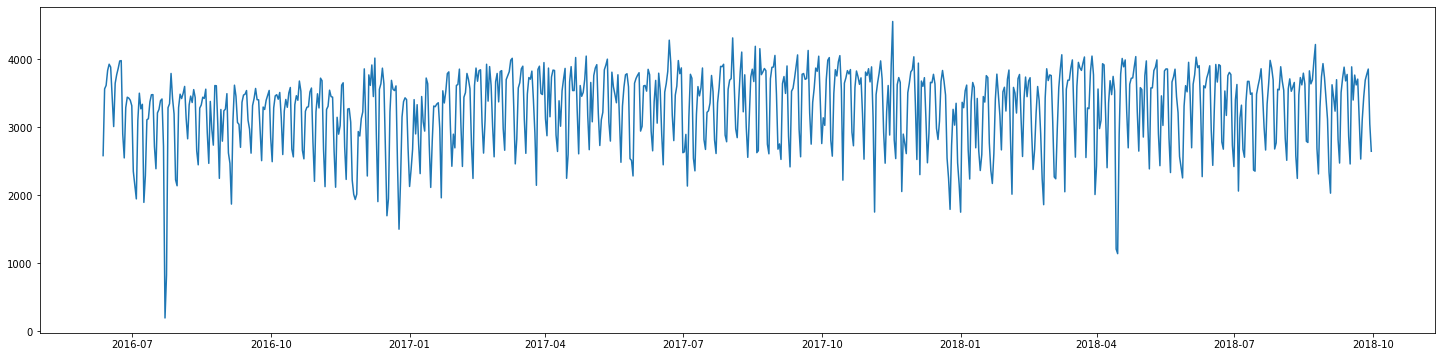

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
dat = pd.read_csv('MinneapolisTraffic.csv')
dat['date']=pd.to_datetime(dat['date'])
fig, ax = plt.subplots(figsize = (25,6))
ax.plot(dat['date'],dat['Traffic'])


Weekly effects apparent, but since the period over which data are collected is short, the variance does not get bigger over time. There is no need to take log transformation.

Although an intercept and the Holiday dummies are included in the dataset, Fourier terms are not. It is best to compute these now.

In [3]:
import numpy as np
from datetime import datetime
#Day of year
dat['DayOfYear'] = dat.loc[:,'date'].dt.dayofyear
#Need to compute days in year. These are not the same since 2016 is a leap year
dat['Year']= dat.loc[:,'date'].dt.year
dat['DaysInYear']=365.0
dat.loc[dat['Year']==2016,'DaysInYear']=366.0
# Now compute Fourier terms
dat['FourS1']=np.sin(2*np.pi*(dat['DayOfYear']/dat['DaysInYear']))
dat['FourC1']=np.cos(2*np.pi*(dat['DayOfYear']/dat['DaysInYear']))
dat['FourS2']=np.sin(2*2*np.pi*(dat['DayOfYear']/dat['DaysInYear']))
dat['FourC2']=np.cos(2*2*np.pi*(dat['DayOfYear']/dat['DaysInYear']))
          
#Split out training and test data
train = dat.loc[(dat['date']<='2018-07-31')]
test = dat.loc[(dat['date']>'2018-07-31')]

### Autoregressive Model (AR2)

Fit an AR(2) model

In [4]:
import statsmodels as sm
import statsmodels.api as smt
fitar2 = sm.tsa.arima.model.ARIMA(train['Traffic'], order = (2,0,0)).fit()
fitar2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Traffic   No. Observations:                  780
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -5943.547
Date:                Fri, 04 Mar 2022   AIC                          11895.095
Time:                        14:30:33   BIC                          11913.732
Sample:                             0   HQIC                         11902.263
                                - 780                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3268.4799     25.604    127.656      0.000    3218.297    3318.662
ar.L1          0.5413      0.031     17.647      0.000       0.481       0.601
ar.L2         -0.3264      0.039     -8.474      0.000      -0.402      -0.251
sigma2      2.429e+05   1.09e+04     22.313      0.000    2.22e+05    2.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                76.47
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.61
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

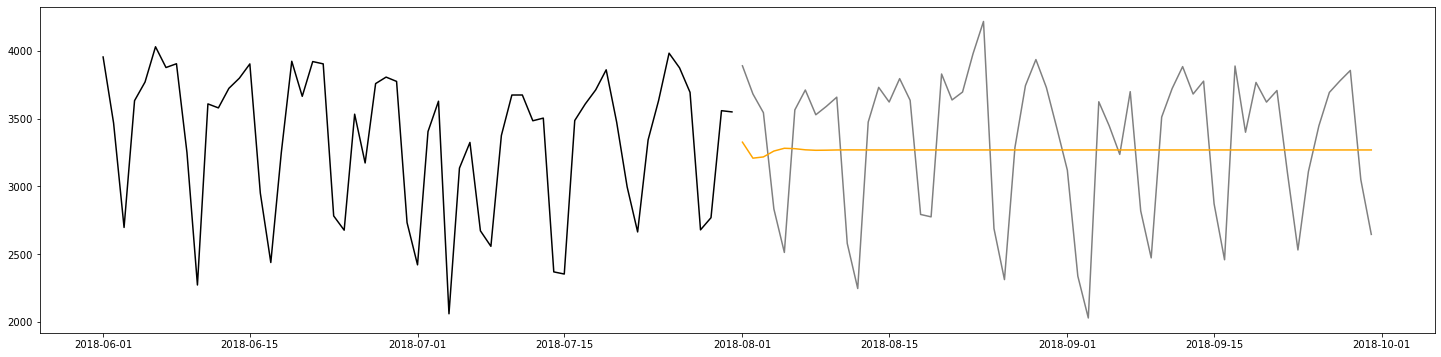

In [5]:
fc_ar2 = fitar2.forecast(len(test))
fig, ax = plt.subplots(1,figsize=(25,6))
end = train.loc[(train['date']>'2018-05-31')]
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_ar2,color='orange')

### MA(2)

Fit an MA(2) model

In [6]:
fitma2 = sm.tsa.arima.model.ARIMA(train['Traffic'], order = (0,0,2)).fit()
fitma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Traffic   No. Observations:                  780
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -5953.926
Date:                Fri, 04 Mar 2022   AIC                          11915.853
Time:                        14:30:34   BIC                          11934.490
Sample:                             0   HQIC                         11923.021
                                - 780                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3268.3744     32.788     99.682      0.000    3204.111    3332.638
ma.L1          0.5613      0.033     17.000      0.000       0.497       0.626
ma.L2          0.0341      0.034      1.008      0.313      -0.032       0.100
sigma2      2.497e+05   1.16e+04     21.533      0.000    2.27e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                88.13
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.69
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

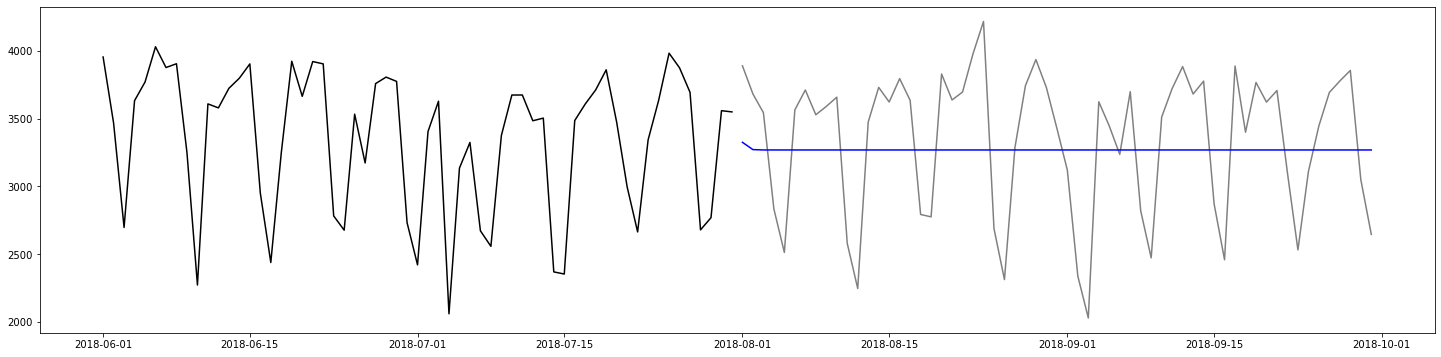

In [7]:
fc_ma2 = fitma2.forecast(len(test))
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_ma2,color='blue')


We can plot results from the AR and MA together

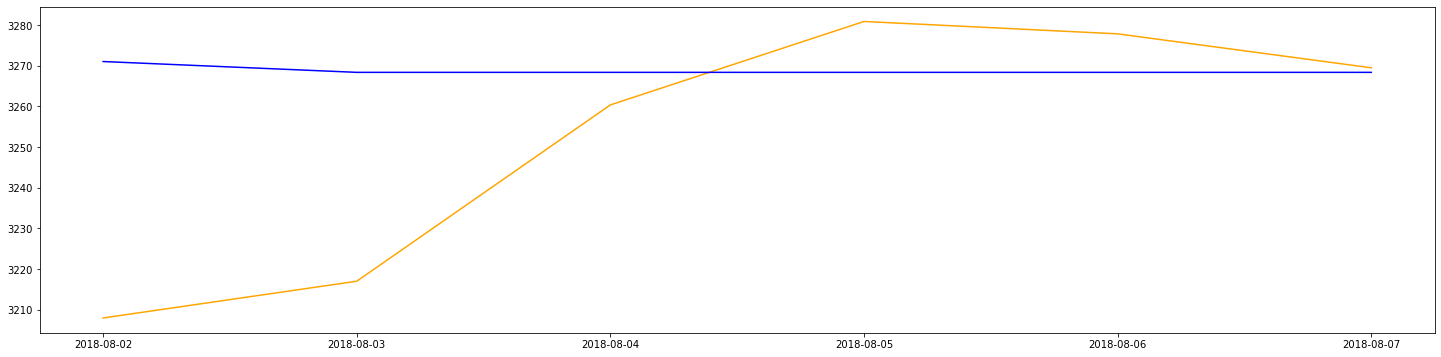

In [8]:
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(test['date'].iloc[1:7],fc_ar2.iloc[1:7],color='orange')
ax.plot(test['date'].iloc[1:7],fc_ma2.iloc[1:7],color='blue')


Notice that both models revert to the mean. However forecasts from the MA do so much quicker. This is a consequence of the MA model having zero ACF past lag q. When forecasting more than $q$ steps ahead, information in $Y$ cannot give you a better forecast than the naive. The AR forecast reverts to the mean much more slowly.

### Auto arima without seasonality

In [9]:
import numpy as np
from statsforecast.models import auto_arima
from statsforecast.arima import auto_arima_f
train_arr = train.to_numpy(dtype='float')
out = auto_arima_f(train_arr[:,1],seasonal=False)
print(out['arma'])

(3, 3, 0, 0, 1, 1, 0)


Auto arima suggests an ARIMA(3,1,3)

In [10]:
fitaans = sm.tsa.arima.model.ARIMA(train['Traffic'], order = (3,1,3)).fit()
fitaans.summary()

/home/anastasios/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Traffic   No. Observations:                  780
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5916.210
Date:                Fri, 04 Mar 2022   AIC                          11846.420
Time:                        14:30:45   BIC                          11879.026
Sample:                             0   HQIC                         11858.962
                                - 780                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1840      0.225      0.816      0.414      -0.258       0.626
ar.L2          0.1480      0.180      0.824      0.410      -0.204       0.500
ar.L3         -0.3606      0.122     -2.951      0.003      -0.600      -0.121
ma.L1         -0.6772      0.221     -3.063      0.002      -1.111      -0.244
ma.L2         -0.6527      0.265     -2.465      0.014      -1.172      -0.134
ma.L3          0.3992      0.094      4.238      0.000       0.215       0.584
sigma2        2.3e+05   9390.212     24.492      0.000    2.12e+05    2.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                93.79
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.60
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

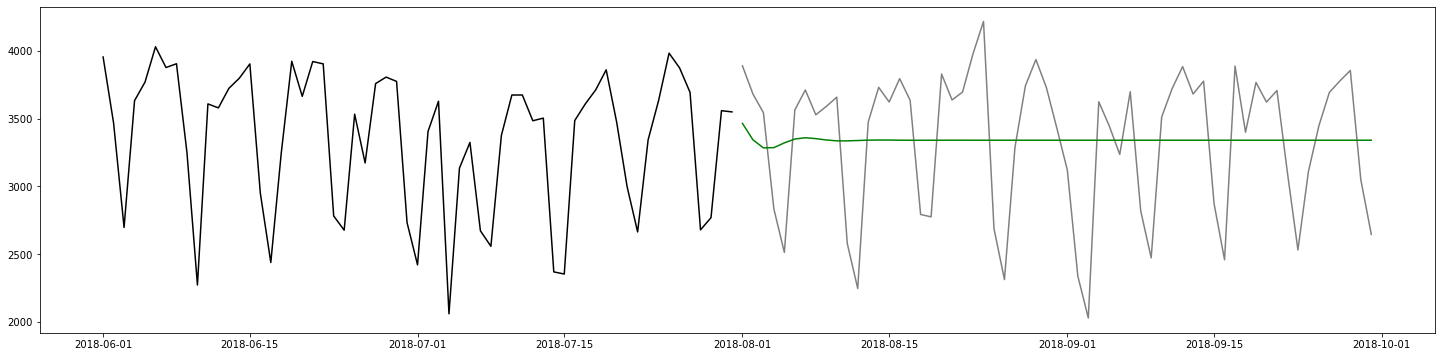

In [11]:
fc_aans = fitaans.forecast(len(test))
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_aans,color='green')


### Auto arima with weekly seasonality

In [12]:
out = auto_arima_f(train_arr[:,1],seasonal=True, period=7)
print(out['arma'])

(0, 3, 2, 1, 7, 0, 1)


Recall that the 
- first element is the (non-seasonal) AR order
- the second element is the (non-seasonal) MA order
- the third element is the seasonal AR order
- the fourth element in the seasonal MA order
- the fifth element is the period
- the sixth element is the order of non-seasonal differencing
- the seventh element is the order of seasonal differencing.


Auto arima suggests a SARIMA (0,0,3)(2,1,1)[7]

In [13]:
fitaas = sm.tsa.arima.model.ARIMA(train['Traffic'], order = (0,0,3),seasonal_order=(2,1,1,7)).fit()
fitaas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Traffic   No. Observations:                  780
Model:             ARIMA(0, 0, 3)x(2, 1, [1], 7)   Log Likelihood               -5604.280
Date:                           Fri, 04 Mar 2022   AIC                          11222.559
Time:                                   14:30:48   BIC                          11255.111
Sample:                                        0   HQIC                         11235.084
                                           - 780                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4118      0.029     14.053      0.000       0.354       0.469
ma.L2          0.1540      0.040      3.859      0.000       0.076       0.232
ma.L3          0.0705      0.041      1.715      0.086      -0.010       0.151
ar.S.L7        0.0826      0.031      2.666      0.008       0.022       0.143
ar.S.L14       0.0498      0.030      1.672      0.094      -0.009       0.108
ma.S.L7       -0.9996      0.444     -2.250      0.024      -1.870      -0.129
sigma2      1.107e+05   5.02e+04      2.203      0.028    1.22e+04    2.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1339.28
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -1.64
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

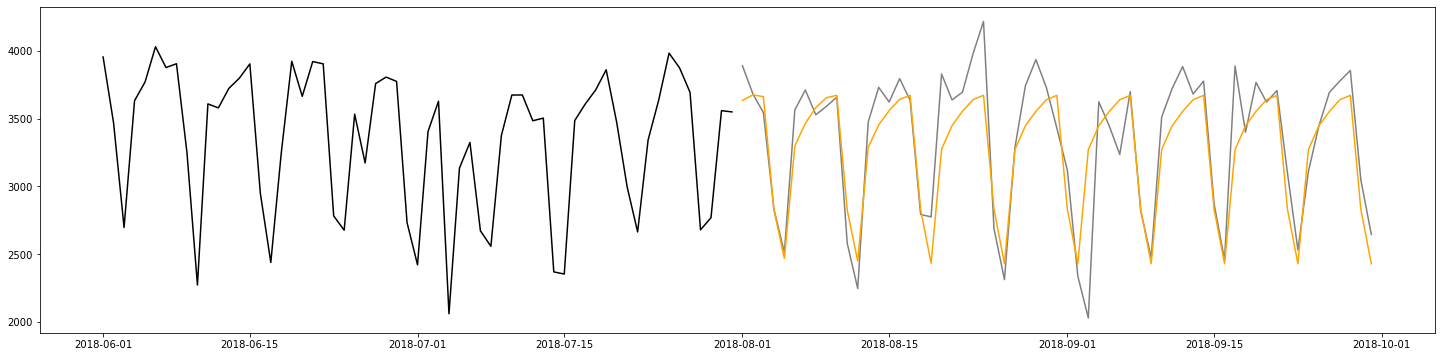

In [14]:
fc_aas = fitaas.forecast(len(test))
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_aas,color='orange')


### Auto arima with seasonality and holiday dummies 

In [15]:
out = auto_arima_f(train_arr[:,1],xreg=train_arr[:,2:3],seasonal=True, period=7)
print(out['arma'])

(0, 3, 2, 1, 7, 0, 1)


In [16]:
fitaash = sm.tsa.arima.model.ARIMA(train['Traffic'],exog=train[['Int','Holiday']],order = (0,0,3),seasonal_order=(2,1,1,7)).fit()
fitaash.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Traffic   No. Observations:                  780
Model:             ARIMA(0, 0, 3)x(2, 1, [1], 7)   Log Likelihood               -5542.037
Date:                           Fri, 04 Mar 2022   AIC                          11102.074
Time:                                   14:30:51   BIC                          11143.927
Sample:                                        0   HQIC                         11118.178
                                           - 780                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Int            0.1517   1462.570      0.000      1.000   -2866.432    2866.736
Holiday     -838.2969     36.275    -23.110      0.000    -909.394    -767.200
ma.L1          0.4130      0.030     13.712      0.000       0.354       0.472
ma.L2          0.1640      0.038      4.344      0.000       0.090       0.238
ma.L3          0.0696      0.041      1.705      0.088      -0.010       0.150
ar.S.L7        0.0933      0.035      2.678      0.007       0.025       0.161
ar.S.L14       0.0066      0.028      0.234      0.815      -0.049       0.062
ma.S.L7       -0.9987      0.109     -9.176      0.000      -1.212      -0.785
sigma2      9.429e+04   1.11e+04      8.467      0.000    7.25e+04    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               922.81
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.08
Prob(H) (two-sided):                  0.42   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

date          2018-08-23 00:00:00
Traffic                   3978.09
Int                             1
Holiday                         1
DayOfYear                     235
Year                         2018
DaysInYear                    365
FourS1                   -0.78565
FourC1                  -0.618671
FourS2                   0.972118
FourC2                  -0.234491
Name: 802, dtype: object


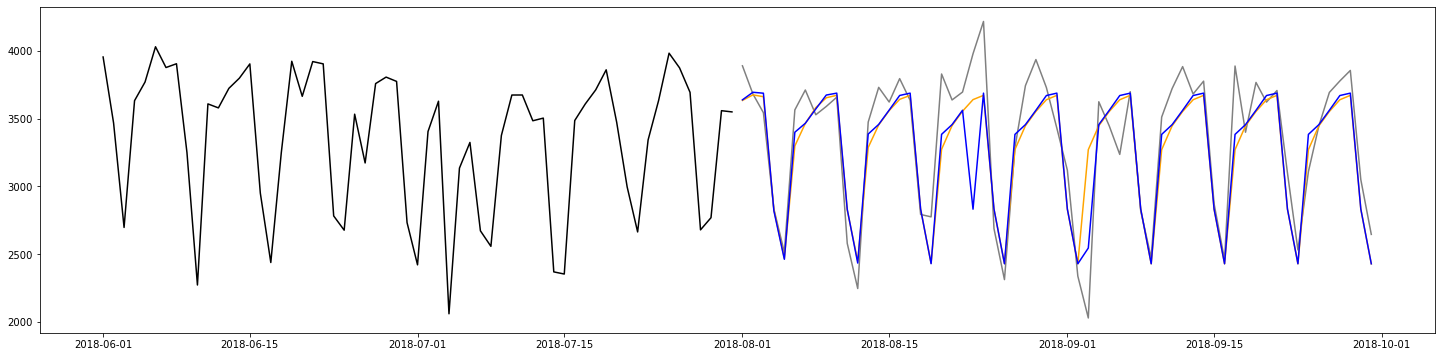

In [24]:
future_x = test[['Int' , 'Holiday']].to_numpy(dtype='float')
fc_aash = fitaash.forecast(len(test),exog = future_x)
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_aas,color='orange')
ax.plot(test['date'],fc_aash,color='blue')

The 3rd September, 2018 was Labor Day (a U.S public holiday). Zoom in on that day

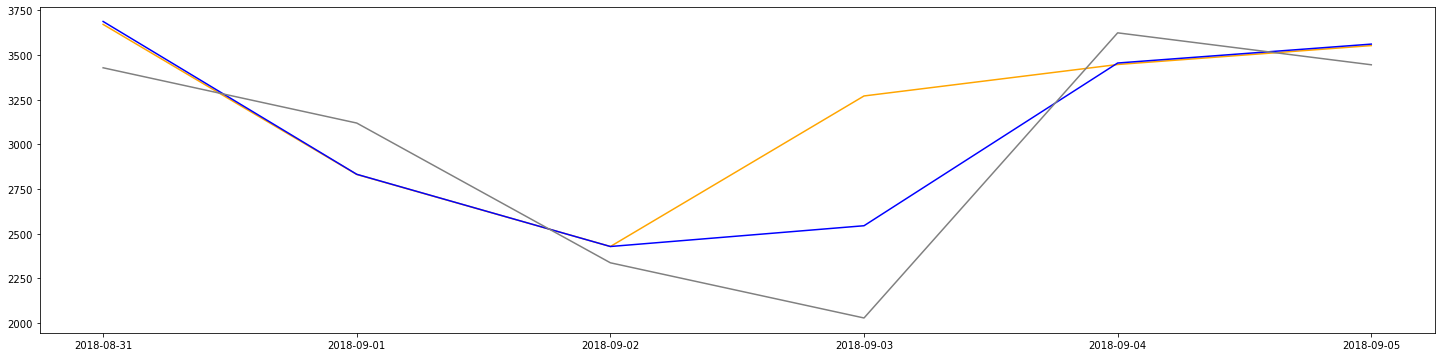

In [18]:
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(test['date'].iloc[30:36],fc_aas.iloc[30:36],color='orange')
ax.plot(test['date'].iloc[30:36],fc_aash.iloc[30:36],color='blue')
ax.plot(test['date'].iloc[30:36],test['Traffic'].iloc[30:36],color='gray')


The model with holiday dummies (blue line) forecasts a lower value relative to the same  model without dummies (orange line). The model with dummies gets closer to the target value (in gray).

If anyone notices, the 23rd of August is also a public holiday, namely the State Fair. Here, the blue line is also lower than the orange line, but in this case, that is not ideal since the State Fair is associated with more traffic. An argument could be made for different dummies depending on the holiday.

### Model with Fourier terms

In [19]:
out = auto_arima_f(train_arr[:,1],xreg=train_arr[:,2:7],seasonal=True, period=7)
print(out['arma'])

(1, 0, 2, 1, 7, 0, 1)


In [20]:
fitaashf = sm.tsa.arima.model.ARIMA(train['Traffic'],exog=train[['Int','Holiday','FourS1','FourC1','FourS2','FourC2']],order = (1,0,0),seasonal_order=(2,1,1,7)).fit()
fitaashf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           Traffic   No. Observations:                  780
Model:             ARIMA(1, 0, 0)x(2, 1, [1], 7)   Log Likelihood               -5530.884
Date:                           Fri, 04 Mar 2022   AIC                          11083.768
Time:                                   14:30:57   BIC                          11134.921
Sample:                                        0   HQIC                         11103.450
                                           - 780                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Int            0.1461   1489.095   9.81e-05      1.000   -2918.427    2918.719
Holiday     -837.0879     37.044    -22.597      0.000    -909.693    -764.483
FourS1        45.2830     30.267      1.496      0.135     -14.040     104.606
FourC1       -45.9132     28.597     -1.606      0.108    -101.962      10.136
FourS2       -25.0630     29.037     -0.863      0.388     -81.974      31.848
FourC2      -119.1236     28.644     -4.159      0.000    -175.265     -62.982
ar.L1          0.4007      0.026     15.308      0.000       0.349       0.452
ar.S.L7        0.0675      0.035      1.921      0.055      -0.001       0.136
ar.S.L14      -0.0179      0.028     -0.634      0.526      -0.073       0.037
ma.S.L7       -0.9992      0.184     -5.423      0.000      -1.360      -0.638
sigma2      9.149e+04   1.74e+04      5.253      0.000    5.74e+04    1.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):              1037.74
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.12
Prob(H) (two-sided):                  0.38   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

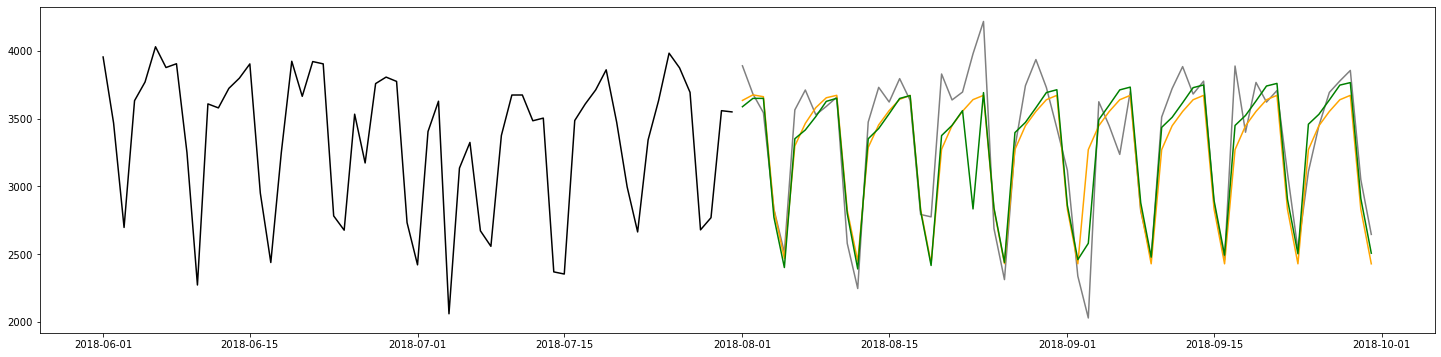

In [21]:
future_x = test[['Int' , 'Holiday','FourS1','FourC1','FourS2','FourC2']].to_numpy(dtype='float')
fc_aashf = fitaashf.forecast(len(test),exog = future_x)
fig, ax = plt.subplots(1,figsize=(25,6))
ax.plot(end['date'],end['Traffic'],color='black')
ax.plot(test['date'],test['Traffic'],color='gray')
ax.plot(test['date'],fc_aas,color='orange')
ax.plot(test['date'],fc_aashf,color='green')